### Manually play around with a line profile to fit AA Tau spectrum

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import timeit

from astropy.io import fits
import astropy.units as u
import pickle as pickle
import os as os
import pandas as pd
from astropy.convolution import convolve

import sys
sys.path.append('/Users/jpw/G/py/spectools_ir/')
from spectools_ir.utils import extract_hitran_data, spec_convol, make_rotation_diagram, get_molmass
from spectools_ir.utils import compute_thermal_velocity, sigma_to_fwhm, fwhm_to_sigma, wn_to_k, spec_convol_R
from spectools_ir.slabspec.slabspec import _spec_convol_klaus
import slabspec_convol

%matplotlib widget
#%matplotlib inline

In [2]:
# user-defined line profile with velocity in m/s
def phi(v):
    sigma = 15  # km/s
    vsys = 0
    vkep = 25
    
    sigma *= 1000    # m/s
    vsys *= 1000
    vkep *= 1000
    
    line_profile = np.exp(-(v-vsys-vkep)**2 / (2*sigma**2)) + np.exp(-(v-vsys+vkep)**2 / (2*sigma**2))
    
    return line_profile

In [3]:
hitran_CO10 = extract_hitran_data('CO', 4.58, 5.2, vup=1)
hitran_CO21 = extract_hitran_data('CO', 4.58, 5.2, vup=2)
hitran_13CO10 = extract_hitran_data('CO', 4.58, 5.2, vup=2)

In [4]:
fitsfile = 'AATau_M.fits'
hdu = fits.open(fitsfile)
data = hdu[1].data
wave = data['WAVELENGTH'][0]*1e-3
flux = data['FLUX'][0]
hdu.close()

Text(0, 0.5, 'Flux [Jy]')

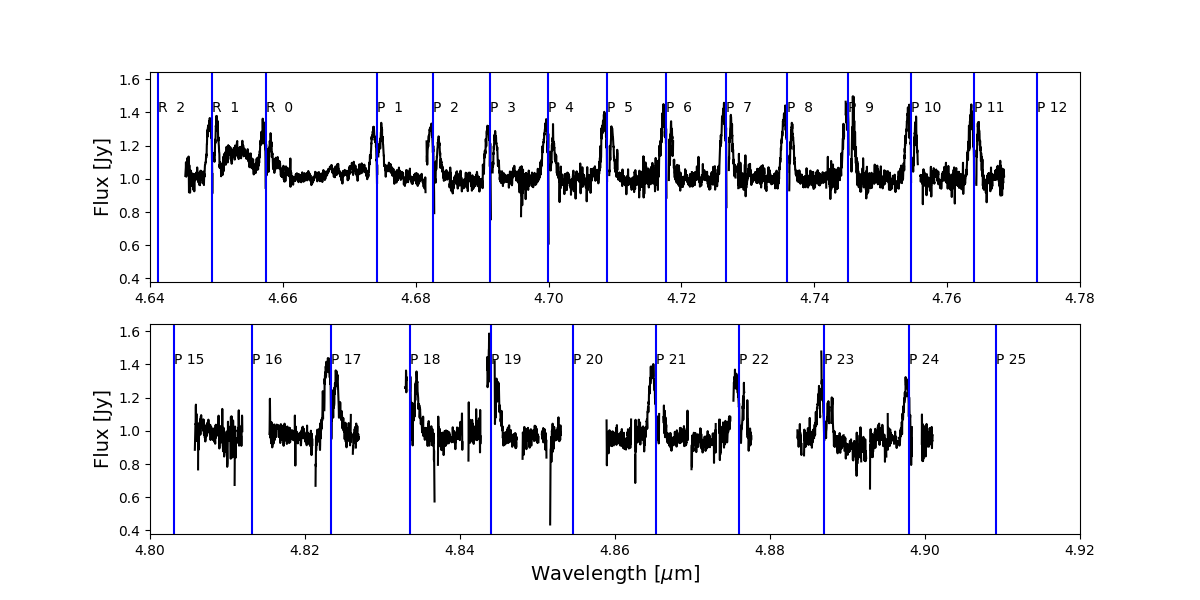

In [5]:
# plot the data (borrowed from Colette's example notebook)
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(211)
ax1.plot(wave, flux, color='black')
wmin, wmax = 4.64, 4.78
ax1.set_xlim(wmin, wmax)
for i, wave1 in enumerate(hitran_CO10['wave']):
    if( (wave1 > wmin) & (wave1 < wmax) ):
        ax1.axvline(wave1, color='blue')
        ax1.text(hitran_CO10['wave'][i], 1.4, hitran_CO10['Qpp'][i].strip())
#for i, wave1 in enumerate(hitran_13CO10['wave']):
#    if( (wave1 > wmin) & (wave1 < wmax) ):
#        ax1.axvline(wave1, color='green')
#        ax1.text(hitran_13CO10['wave'][i], 1.4, hitran_13CO10['Qpp'][i].strip())
ax1.set_ylabel('Flux [Jy]', fontsize=14)

ax2 = fig.add_subplot(212)
ax2.plot(wave, flux, color='black')
wmin, wmax = 4.80, 4.92
ax2.set_xlim(wmin, wmax)
for i, wave1 in enumerate(hitran_CO10['wave']):
    if( (wave1 > wmin) & (wave1 < wmax) ):
        ax2.axvline(wave1, color='blue')
        ax2.text(hitran_CO10['wave'][i], 1.4, hitran_CO10['Qpp'][i].strip())
ax2.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
ax2.set_ylabel('Flux [Jy]', fontsize=14)

In [6]:
start_time = timeit.default_timer()

# slab model parameters
au = 1.5e11      # au in m
N = 1e22         # column density of molecule (not H2) in m-2
T = 750         # temperature in K
A = (0.5*au)**2  # emitting area in m-2
X13 = 1/60       # 13CO/CO ratio

spec_CO10 = slabspec_convol.make_spec_convol('CO', N, T, A, wmin=4.58, wmax=5.2, d_pc=140., res=1e-5, vup=1, phi=phi)

# run more models for different transitions (ok since they don't overlap at thermal linewidths)
spec_CO21 = slabspec_convol.make_spec_convol('CO', N, T, A, wmin=4.58, wmax=5.2, d_pc=140., res=1e-5, vup=2, phi=phi)
spec_13CO10 = slabspec_convol.make_spec_convol('CO', X13*N, T, A, wmin=4.58, wmax=5.2, d_pc=140., res=1e-5, vup=1, phi=phi, isotopologue_number=2)

elapsed = timeit.default_timer() - start_time
print(f'Model took {elapsed:5.2f} seconds')

Reading partition function from:  https://hitran.org/data/Q/q26.txt
Reading partition function from:  https://hitran.org/data/Q/q26.txt
Reading partition function from:  https://hitran.org/data/Q/q27.txt
Model took  4.61 seconds


In [7]:
# normalize by the continuum - in principle constrained by obs but here a free (fudge) parameter
scale = 5.0
wave_model = spec_CO10['spectrum']['wave']
flux_model = 1 + scale * spec_CO10['spectrum']['convolflux']

# here's what we would do if we wanted to include CO v=2-1 and 13CO in the model
flux_model = 1 + scale * (spec_CO10['spectrum']['convolflux'] + spec_CO21['spectrum']['convolflux'] + spec_13CO10['spectrum']['convolflux'])

# final step is to convolve to the resolving power of the data
R = 25000
flux_model_R = _spec_convol_klaus(wave_model, flux_model, R)

Text(0, 0.5, 'Flux [Jy]')

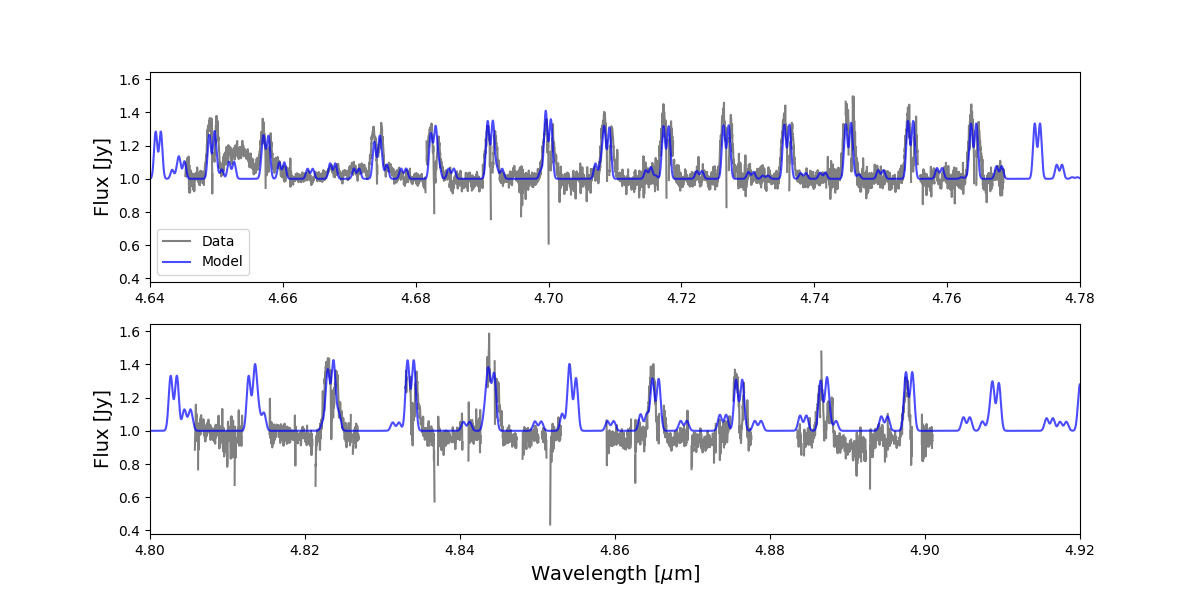

In [8]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(211)
ax1.plot(wave, flux, color='gray', label='Data')
ax1.plot(wave_model, flux_model_R, color='blue', label='Model', alpha=0.7)
wmin, wmax = 4.64, 4.78
ax1.set_xlim(wmin, wmax)
ax1.set_ylabel('Flux [Jy]', fontsize=14)
ax1.legend()

ax2 = fig.add_subplot(212)
ax2.plot(wave, flux, color='gray', label='Data')
ax2.plot(wave_model, flux_model_R, color='blue', label='Model', alpha=0.7)
wmin, wmax = 4.80, 4.92
ax2.set_xlim(wmin, wmax)
ax2.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
ax2.set_ylabel('Flux [Jy]', fontsize=14)

#plt.savefig('test_fit.png')